<a href="https://colab.research.google.com/github/DauoDauo/ABC/blob/master/Detecci%C3%B3n_de_noticias_falsas_utilizando_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

Load dataset

In [6]:
dataset_noticias=pd.read_csv("/content/sample_data/fake_or_real_news.csv")


Data Analysis

In [7]:
dataset_noticias.head(10)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [8]:
dataset_noticias.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [9]:
dataset_noticias.label.value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

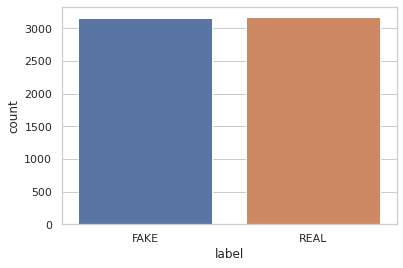

In [10]:
sns.set_theme(style="whitegrid")
sns.countplot(x=dataset_noticias["label"])

In [11]:
dataset_noticias.head(3)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL


In [12]:
dataset_noticias["text"]=dataset_noticias["title"]+dataset_noticias["text"]

In [13]:
dataset_noticias=dataset_noticias[["text","label"]]

In [14]:
dataset_noticias['label'] = dataset_noticias['label'].map({'REAL':1, 'FAKE':0})

In [15]:
dataset_noticias.sample(5)

,text,label
3015,Why does ISIS keep making enemies?Peter Bergen...,1
4877,Long Odds Ahead for Obama on His Troubled Trad...,1
826,The Empire Files: Inside Palestine's Refugee C...,0
4479,Judge Temporarily Halts Obama's Immigration Ac...,1
4176,The GOP Is Writing Off 30 Percent of the Ameri...,1


In [16]:
dataset_noticias.label[4000]

1

In [17]:
dataset_noticias.text[4000]

'Why The Obamacare Doomsday Cult Can\'t Admit It\'s WrongBut when Congress debated and passed the Patient Protection and Affordable Care Act in 2009 and 2010, opponents were nearly unified in offering grim Keech-like predictions. With Obamacare now in full effect, and the economy on a decided upswing, the dour prognostications are starting to look like Keech\'s flying saucers. At least if you believe the data. A look at Festinger\'s theories, though, can explain why that won\'t matter, and why Americans can expect a continued drumbeat of doom, even as the prophecies fail.\n\n“It certainly has not had the baleful effects the critics were predicting,” said Paul Van de Water, a senior fellow at the Center on Budget and Policy Priorities who supports the law, but never thought it would have much economic impact. “On balance it may be a modest plus, to the extent that it has contributed to the slowdown of growth in health care costs.”\n\nBut that\'s not how Capitol Hill’s gloomsday cult see

In [18]:
max_len=100
data_text=dataset_noticias["text"]
data_label=dataset_noticias["label"]


In [19]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [20]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [21]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

In [23]:
def tokenize(X):
    
    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [24]:
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [25]:
maxlen=100

create bert model

In [26]:
def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(maxlen,),dtype=tf.int32)
    input_mask=Input(shape=(maxlen,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model
    
    

In [27]:
model=create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [28]:
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

In [30]:
history = model.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = Y_train, epochs=2, validation_split = 0.2, batch_size = 30, callbacks=[callback])

Epoch 1/2
136/136 [==============================] - 4697s 34s/step - loss: 0.5390 - accuracy: 0.7163 - val_loss: 0.2778 - val_accuracy: 0.8895
Epoch 2/2
136/136 [==============================] - 4730s 35s/step - loss: 0.2673 - accuracy: 0.8984 - val_loss: 0.2239 - val_accuracy: 0.9201


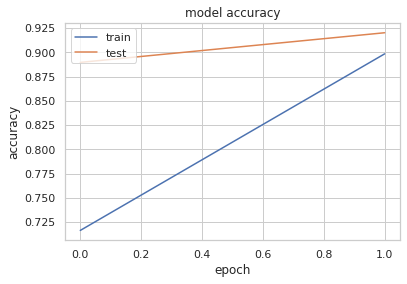

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

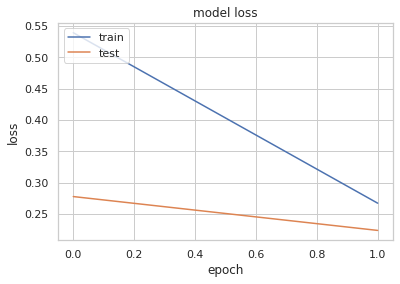

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [33]:
y_pred = np.where(model.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)

40/40 [==============================] - 438s 11s/step


Confusion matrix

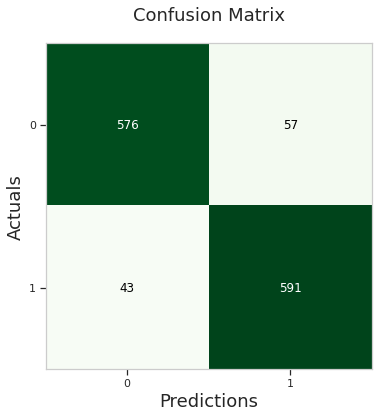

In [34]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [35]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       633
           1       0.91      0.93      0.92       634

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267

